# 1 

A partir del fichero "US_Crime_Rates_1960_2014", se pide:

1. Tratar el dataset como una serie temporal a partir de la columna Year. Siempre el eje X será el nuevo índice Year.
2. Dibujar todas las columnas numéricas.
3. Como se puede ver en el punto 2, la columna "Population" tiene una magnitud diferente a la de las demás columnas: Dibuja la misma gráfica que antes pero con dos resoluciones diferentes para que se puedan observar con mejor detalle todas las columnas. 
4. A partir de ahora y para el resto del ejercicio, borra las columnas "Population" y "Total" ¿Qué columnas tienen mejor correlación? 
5. A partir de las cinco columnas que tengan mejor correlación con la columna "Murder", entrena un modelo de regresión no lineal a partir de polinomio de grado 6. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento.
6. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones=23 y n_repeats=7.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split, learning_curve
from sklearn.preprocessing import PolynomialFeatures

/home/jose/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


<AxesSubplot:xlabel='Year'>

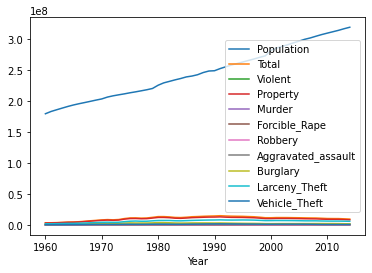

In [3]:
df = pd.read_csv("../data/US_Crime_Rates_1960_2014.csv")

df.set_index("Year", inplace=True)
df.plot()

In [4]:
df.head()

,Population,Total,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft
Year,,,,,,,,,,,
1960,179323175,3384200,288460,3095700,9110,17190,107840,154320,912100,1855400,328200
1961,182992000,3488000,289390,3198600,8740,17220,106670,156760,949600,1913000,336000
1962,185771000,3752200,301510,3450700,8530,17550,110860,164570,994300,2089600,366800
1963,188483000,4109500,316970,3792500,8640,17650,116470,174210,1086400,2297800,408300
1964,191141000,4564600,364220,4200400,9360,21420,130390,203050,1213200,2514400,472800


<AxesSubplot:xlabel='Year'>

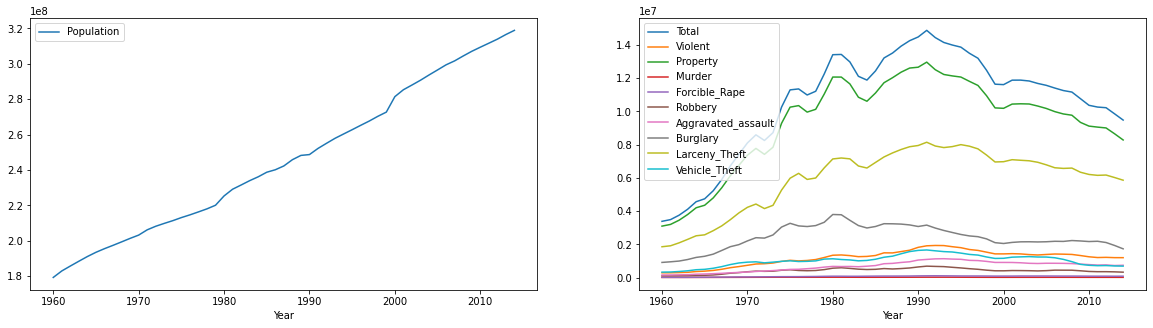

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
df['Population'].plot(ax=ax[0], legend=True)
df.drop('Population', axis=1).plot(ax=ax[1])

In [6]:
df = df.drop(['Total', 'Population'], axis=1)

<AxesSubplot:>

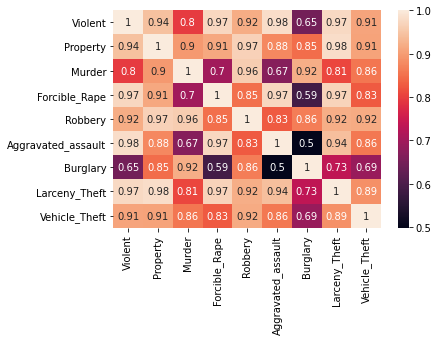

In [7]:
sns.heatmap(df.corr(), annot=True)

In [8]:
corr_serie = df.corr().stack()
corr_serie = corr_serie[~(corr_serie == 1)]
corr_serie.sort_values(ascending=False)['Murder'].head(5)

Robbery          0.960156
Burglary         0.920207
Property         0.895641
Vehicle_Theft    0.856600
Larceny_Theft    0.806279
dtype: float64

In [9]:
df = df[['Robbery', 'Burglary', 'Property', 'Vehicle_Theft', 'Larceny_Theft', 'Murder']]

In [10]:
df.head()

,Robbery,Burglary,Property,Vehicle_Theft,Larceny_Theft,Murder
Year,,,,,,
1960,107840,912100,3095700,328200,1855400,9110
1961,106670,949600,3198600,336000,1913000,8740
1962,110860,994300,3450700,366800,2089600,8530
1963,116470,1086400,3792500,408300,2297800,8640
1964,130390,1213200,4200400,472800,2514400,9360


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 1960 to 2014
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Robbery        55 non-null     int64
 1   Burglary       55 non-null     int64
 2   Property       55 non-null     int64
 3   Vehicle_Theft  55 non-null     int64
 4   Larceny_Theft  55 non-null     int64
 5   Murder         55 non-null     int64
dtypes: int64(6)
memory usage: 3.0 KB


In [12]:
X = df.iloc[:, :-1].to_numpy()
target = df['Murder'].to_numpy()

In [13]:
seed = 42

In [14]:
model = LinearRegression()
poly_trans = PolynomialFeatures(degree=6)
X_poly = poly_trans.fit_transform(X)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, target, test_size=0.1, random_state=seed)

In [16]:
k_fold = RepeatedKFold(n_splits=23, n_repeats=7, random_state=seed)

Vamos a definir dos funciones para crear dos gráficas

In [26]:
# Entrenamiento cruzado
def training_cross_validation(model, X, y, k_fold):
    # Esta curva representa la curva de entrenamiento y de validación realizando un cross validation para obtener los índices
    fig, ax = plt.subplots()
    val_score = []
    train_score = []
    tamano = []
    for i, (train, val) in enumerate(k_fold.split(X)):
        model.fit(X[train], y[train])
        score_val = model.score(X[val], y[val])
        val_score.append(score_val)
        score_train = model.score(X[train], y[train])
        train_score.append(score_train)
        tamano.append(i)
    
    ax.plot(tamano, train_score, label='Training')
    ax.plot(tamano, val_score, label='Validation')
    ax.set_title(model.__class__.__name__)
    ax.set_xlabel('Número de iteraciones')
    ax.set_ylabel('Score')
    ax.legend()
    
    return ax

In [27]:
# Curva de aprendizaje
def plot_learning_curve(model, X, y):
    # Esta curva representa la curva de entrenamiento y de validación cuando se entrena el modelo con una parte de los datos
    # cada vez más grande
    fig, ax = plt.subplots()    
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    ax.plot(train_sizes,np.mean(train_scores,axis=1), label='Train curve')
    ax.plot(train_sizes,np.mean(test_scores,axis=1), label='Validation curve')
    ax.set_title(model.__class__.__name__)
    ax.set_xlabel('Número de datos')
    ax.set_ylabel('Score')
    ax.legend()
    return ax


<AxesSubplot:title={'center':'LinearRegression'}, xlabel='Número de iteraciones', ylabel='Score'>

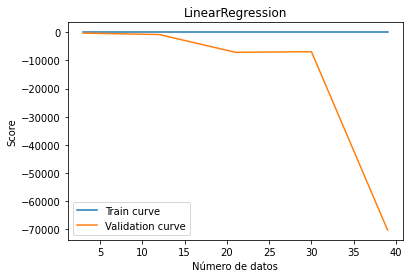

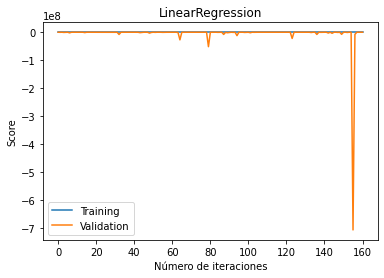

In [29]:
plot_learning_curve(model, X_train, y_train)
training_cross_validation(model, X_train, y_train, k_fold)